In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext tensorboard

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import os
from datetime import datetime
import tensorflow as tf
import sklearn
import time

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# make results reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(13)

# Language models

A statistical **language model** is a probability distribution over sequences of words. Given such a sequence, say of length $m$, it assigns a probability $P(w_1,\ldots,w_m)$ to the whole sequence. As the number of words coming before a word $w_i$, varies depending on its location
in the input document, $P(w_1,\ldots,w_m)$ is usually conditioned on a window of $n$ previous words rather than all previous words:

$$ P(w_1,\ldots,w_m) = \prod^m_{i=1} P(w_i\mid w_1,\ldots,w_{i-1})
 \approx \prod^m_{i=1} P(w_i\mid w_{i-n},\ldots,w_{i-1}) $$

This equation is especially useful for translation systems and speech systems as it is used to  determining whether a word sequence is an accurate translation of an input sentence. In existing language translation systems,
for each phrase / sentence translation, the software generates a number of alternative word sequences (e.g. {I have, I had, I has, me have, me
had}) and scores them to identify the most likely translation sequence.
In machine translation, the model chooses the best word ordering
for an input phrase by choosing the most probable based on a language model, scoring each output.

Data sparsity is a major problem in building language models, as we will see. Most possible word sequences are not observed in training. One solution is to make the assumption that the probability of a word only depends on the previous $n$ words. This is known as an $n$-gram model or unigram model when $n=1$. The unigram model is also known as the bag of words model. (We saw how to compute $n$-grams in Keras in the second video of this section)

Estimating the *relative likelihood* of different phrases is useful in many *natural language processing* applications, especially those that generate text as an output. Language modeling is used in speech recognition, machine translation, part-of-speech tagging, parsing, Optical Character Recognition, handwriting recognition, information retrieval and other applications.

## n-gram Language models

In an $n$-gram model, the probability $P(w_1,\ldots,w_m)$ of observing the sentence $w_1,\ldots,w_m$ is approximated as

$$
P(w_1,\ldots,w_m) = \prod^m_{i=1} P(w_i\mid w_1,\ldots,w_{i-1})
 \approx \prod^m_{i=1} P(w_i\mid w_{i-(n-1)},\ldots,w_{i-1})
$$

It is assumed that the probability of observing the $i^{th}$ word $w_i$ in the context history of the preceding $i-1$ words can be approximated by the probability of observing it in the shortened context history of the preceding $n-1$ words ($n^{th}$ order Markov property).

The conditional probability can be calculated from $n$-gram model frequency counts:

$$
P(w_i\mid w_{i-(n-1)},\ldots,w_{i-1}) = \frac{\mathrm{count}(w_{i-(n-1)},\ldots,w_{i-1},w_i)}{\mathrm{count}(w_{i-(n-1)},\ldots,w_{i-1})}
$$

The terms **bigram** and **trigram** language models denote $n$-gram models with $n=2$ and $n=3$, respectively.

Typically, the $n$-gram model probabilities are not derived directly from frequency counts, because models derived this way have severe problems when confronted with any $n$-grams that have not been explicitly seen before. Instead, some form of smoothing is necessary, assigning some of the total probability mass to unseen words or $n$-grams. Various methods are used, from simple "add-one" smoothing (assign a count of 1 to unseen $n$-grams, as an uninformative prior) to more sophisticated models, such as Good-Turing discounting or back-off models.

n-gram language models have two main issues, that is the models are very sparse, as the word sequence under evaluation may never appear in our corpus, and storage issues, as we need to store all the $n$-grams that we saw in our corpus, which increases as $n$ increases.

## Neural Network Language models

Neural language models (or *continuous space language models*) use continuous representations or embeddings of words to make their predictions.

Continuous space embeddings help to alleviate the **curse of dimensionality** in language modeling (As we saw in the first video with word embeddings), specifically as language models are trained on larger and larger texts, the number of unique words (the vocabulary) increases. The number of possible sequences of words increases exponentially with the size of the vocabulary, causing a data sparsity problem because of the exponentially many sequences. Thus, statistics are needed to properly estimate probabilities. Neural networks avoid this problem by representing words in a distributed way, as non-linear combinations of weights in a neural net. An alternate description is that a neural net approximates the language function. The neural net architecture might be feed-forward or recurrent, and while the former is simpler the latter is more common.

Typically, neural net language models are constructed and trained as probabilistic classifier's that learn to predict a probability distribution

$$P(w_t | \mathrm{context}) \, \forall t \in V$$

I.e., the network is trained to predict a probability distribution over the vocabulary, given some linguistic context. This is done using standard neural net training algorithms such as stochastic gradient descent with backpropagation. The context might be a fixed-size window of previous words, so that the network predicts

$$P(w_t | w_{t-k}, \dots, w_{t-1})$$

from a feature vector representing the previous $k$ words. Another option is to use "future" words as well as "past" words as features, so that the estimated probability is

$$P(w_t | w_{t-k}, \dots, w_{t-1}, w_{t+1}, \dots, w_{t+k})$$

This is called a **bag-of-words** model. When the feature vectors for the words in the context are combined by a continuous operation, this model is referred to as the continuous bag-of-words architecture (CBOW).

A third option that trains slower than the CBOW but performs slightly better is to invert the previous problem and make a neural network learn the context, given a word. More formally, given a sequence of training words $w_1, w_2, w_3, \dots, w_T$, one maximizes the average log-probability

$$\frac{1}{T}\sum_{t=1}^T \sum_{-k \leq j \leq k, j \neq 0} \log P(w_{t+j} | w_t)$$

where $k$, the size of the training context, can be a function of the center word $w_t$. This is called a **skip-gram** language model. Bag-of-words and skip-gram models are the basis of the word2vec word embedding model (First video of this section).

Instead of using neural net language models to produce actual probabilities, it is common to instead use the distributed representation encoded in the networks' "hidden" layers as representations of words; each word is then mapped onto an $n$-dimensional real vector called the word embedding, where $n$ is the size of the layer just before the output layer. The representations in skip-gram models have the distinct characteristic that they model semantic relations between words as linear combinations, capturing a form of compositionality. For example, in some such models, if $v$ is the function that maps a word $w$ to its $n$-$d$ vector representation, then

$$v(\mathrm{king}) - v(\mathrm{male}) + v(\mathrm{female}) \approx v(\mathrm{queen})$$.

# Language model in Keras (Recurrent character-model)

Lets train a language model, where a character-based recurrent neural network and sample from it to generate text similar to that from the corpus that we trained it on.

Lets choose the corpus of [Shakespeare's writing](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Given a sequence of characters from this data ("Shakespear"), train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

The following is sample output when the model in this tutorial trained for 30 epochs, and started with the string "Q":

<pre>
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
</pre>

While some of the sentences are grammatical, most do not make sense. The model has not learned the meaning of words, but consider:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text.
* The structure of the output resembles a play—blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.
* As demonstrated below, the model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.

## Download the process the dataset

In [2]:
path_to_file = tf.keras.utils.get_file(
    'shakespeare.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

# We can look into the text
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print('Length of text: {} characters'.format(len(text)))
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))

# Take a look at the first 250 characters in text
print('\n', text[:250])

Length of text: 1115394 characters
65 unique characters

 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



## Process the text

### Vectorize the text

Before training, we need to map strings to a numerical representation. Create two lookup tables: one mapping characters to numbers, and another for numbers to characters.

In [3]:
# Creating a mapping from unique characters to indices
char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

Now we have an integer representation for each character. Notice that we mapped the character as indexes from 0 to `len(unique)`.

In [4]:
print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [5]:
# Show how the first 13 characters from the text are mapped to integers
print(
    '{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]),
                                                        text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


### The prediction task

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, we can model what is the next character

### Create training examples and targets

Next divide the text into example sequences. Each input sequence will contain `seq_length` characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of `seq_length+1`. For example, say `seq_length` is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices.

In [6]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

F
i
r
s
t


The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [7]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

for item in sequences.take(5):
    print('\n', repr(''.join(idx2char[item.numpy()])))


 'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '

 'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'

 "now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"

 "ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"

 'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For each sequence, duplicate and shift it to form the input and target text by using the `map` method to apply a simple function to each batch:

In [8]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text


dataset = sequences.map(split_input_target)

Print the first examples input and target values:

In [9]:
for input_example, target_example in dataset.take(1):
    print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print('\nTarget data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. At the next timestep, it does the same thing but the `RNN` considers the previous step context in addition to the current input character.

In [10]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


### Create training batches

We used `tf.data` to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [11]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

## Build The Model

We will use the following:
* `tf.keras.layers.Embedding`: The input layer. A trainable lookup table that will map the numbers of each character to a vector with `embedding_dim` dimensions;
* `tf.keras.layers.LSTM`: As our recurrent language model
* `tf.keras.layers.Dense`: The output layer, with `vocab_size` outputs.

In [12]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [13]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.LSTM(rnn_units,
                             return_sequences=True,
                             stateful=True,
                             recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [14]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

## Try the model

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [15]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape,
          "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is `100` but the model can be run on inputs of any length:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to _sample_ from this distribution as taking the _argmax_ of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

In [17]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

This gives us, at each timestep, a prediction of the next character index:

In [18]:
sampled_indices

array([ 7, 15,  8, 17,  2, 24, 32, 11, 12, 61, 13, 40, 50, 42, 22, 24,  7,
       49, 49, 12,  7, 33,  2, 31, 54, 27, 37,  9, 45, 53, 62,  5, 37, 48,
       63,  8, 52, 59, 58, 11, 29, 30, 42, 20, 43, 32, 43, 35,  8,  0,  7,
       56, 63, 16, 32, 52, 19, 13, 44, 16, 43, 30, 17, 64, 27, 59, 60, 23,
       61, 22, 21, 57, 52,  1, 36, 60, 40, 49, 18, 58, 11, 21,  5, 61, 19,
        6, 47, 60, 61,  8, 45, 37, 38,  8,  6, 60, 19, 26, 17, 23])

Decode these to see the text predicted by this untrained model:

In [19]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'ere well compounded.\nMy sovereign liege, I do beseech your majesty\nTo take our brother Clarence to y'

Next Char Predictions: 
 "-C.E!LT;?wAbldJL-kk?-U!SpOY3gox'Yjy.nut;QRdHeTeW.\n-ryDTnGAfDeREzOuvKwJIsn XvbkFt;I'wG,ivw.gYZ.,vGNEK"


## Train the model

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_categorical_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions.

Because our model returns logits, we need to set the `from_logits` flag.


In [20]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape,
      " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.1738253


Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.keras.optimizers.Adam` with default arguments and the loss function.

In [21]:
model.compile(optimizer='adam', loss=loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training

We will also use early stopping during training

In [22]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

### Execute the training

In [23]:
EPOCHS=30

history = model.fit(dataset,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_callback])

Epoch 1/30
172/172 [==============================] - 5s 29ms/step - loss: 2.5532
Epoch 2/30
172/172 [==============================] - 5s 28ms/step - loss: 1.8585
Epoch 3/30
172/172 [==============================] - 5s 29ms/step - loss: 1.6186
Epoch 4/30
172/172 [==============================] - 5s 28ms/step - loss: 1.4912
Epoch 5/30
172/172 [==============================] - 5s 28ms/step - loss: 1.4130
Epoch 6/30
172/172 [==============================] - 5s 29ms/step - loss: 1.3579
Epoch 7/30
172/172 [==============================] - 5s 29ms/step - loss: 1.3137
Epoch 8/30
172/172 [==============================] - 5s 29ms/step - loss: 1.2742
Epoch 9/30
172/172 [==============================] - 5s 29ms/step - loss: 1.2376
Epoch 10/30
172/172 [==============================] - 5s 29ms/step - loss: 1.2028
Epoch 11/30
172/172 [==============================] - 5s 29ms/step - loss: 1.1669
Epoch 12/30
172/172 [==============================] - 5s 29ms/step - loss: 1.1292
Epoch 13/30
1

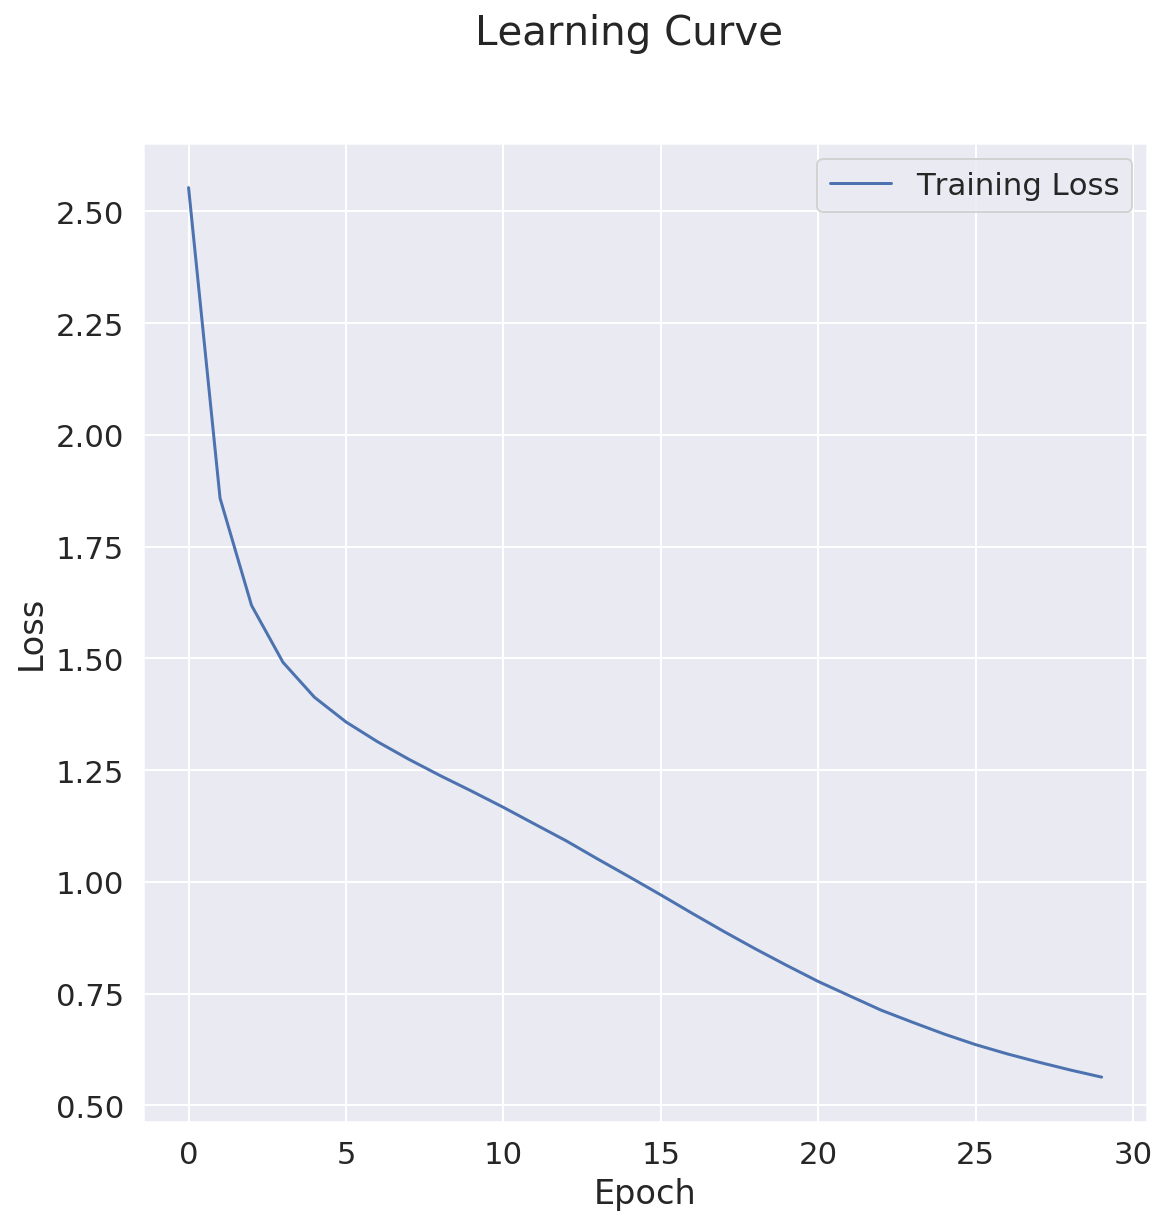

In [34]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
fig = plt.Figure(figsize=(15, 8))

epochs_to_mean = 1

plt.plot(history_df['loss'].rolling(epochs_to_mean).mean(), 'b')
plt.suptitle('Learning Curve')
plt.legend(['Training Loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different `batch_size`, we need to rebuild the model and restore the weights from the checkpoint.


In [24]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_30'

In [25]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters.

Looking at the generated text, we'll see the model knows when to capitalize, make paragraphs and imitates a Shakespeare-like writing vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

In [40]:
def generate_text(model, start_string, temperature = 1.0):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions, num_samples=1)[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [28]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: ANTIUS:
All is not pass'd with me double. Good, good nurse, and out of thy entrails
Year boundy light: and more, sir; ask him,
That think you yet?

First Servingman:
Art, mighty lier; thy house had I half my charge themselves.
Witch the king doth quite black frozes my trust,
Or lace I happy in the country, let him close,
And smiles in them.

LUCIO:
I fear he with her breath.

AUTOLYCUS:
He hath ask it?
The rest is so; there is no linger.

KING EDWARD IV:
Nay, let us better; it is not day is many of his morn.

First Murderer:
Warwick, shall all so early seen the truth.
Would have you heard of such a discontented sixtern,
I am not book in aftem the loss.

Servant:
My lord, this deadly well merry service.

BAPTISTA:
Why, here's a very needly.

PROSPERO:
Volunt,
Are you a madam? True, I have offended me
Aftend the Duke of Hortens.

MERCIUS:
I do do't, low it ce, 'manished;' that I say, that
justice and help of heart
Of my crown'd brother: if we do not ser;
Plainly to him, and read
L

The easiest thing we can do to improve the results it to train it for longer.

We can also experiment with a different start string, or try adding another RNN layer to improve the model's accuracy, or adjusting the temperature parameter to generate more or less random predictions.

## Advanced: Customized Training

The above training procedure is simple, but does not give us much control.

So now that we've seen how to run the model manually let's unpack the training loop, and implement it ourselves. This gives a starting point if, for example, to implement _curriculum learning_ to help stabilize the model's open-loop output.

We will use `tf.GradientTape` to track the gradients.

The procedure works as follows:

* First, initialize the RNN state. We do this by calling the `tf.keras.Model.reset_states` method.

* Next, iterate over the dataset (batch by batch) and calculate the *predictions* associated with each.

* Open a `tf.GradientTape`, and calculate the predictions and loss in that context.

* Calculate the gradients of the loss with respect to the model variables using the `tf.GradientTape.grads` method.

* Finally, take a step downwards by using the optimizer's `tf.train.Optimizer.apply_gradients` method.


In [35]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [36]:
optimizer = tf.keras.optimizers.Adam()

In [37]:
@tf.function
def train_step(inp, target):
    with tf.GradientTape() as tape:
        predictions = model(inp)
        loss = tf.reduce_mean(
            tf.keras.losses.sparse_categorical_crossentropy(
                target, predictions, from_logits=True))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss

In [38]:
# Training step
EPOCHS = 30

for epoch in range(EPOCHS):
    start = time.time()

    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()

    for (batch_n, (inp, target)) in enumerate(dataset):
        loss = train_step(inp, target)

        if batch_n % 100 == 0:
            template = 'Epoch {} Batch {} Loss {}'
            print(template.format(epoch+1, batch_n, loss))

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.174138069152832
Epoch 1 Batch 100 Loss 2.2958357334136963
Epoch 1 Loss 2.0846
Time taken for 1 epoch 7.204745531082153 sec

Epoch 2 Batch 0 Loss 2.2986528873443604
Epoch 2 Batch 100 Loss 1.8473788499832153
Epoch 2 Loss 1.7575
Time taken for 1 epoch 5.828127145767212 sec

Epoch 3 Batch 0 Loss 1.7117501497268677
Epoch 3 Batch 100 Loss 1.6100497245788574
Epoch 3 Loss 1.5299
Time taken for 1 epoch 5.771391153335571 sec

Epoch 4 Batch 0 Loss 1.554146409034729
Epoch 4 Batch 100 Loss 1.4532296657562256
Epoch 4 Loss 1.5037
Time taken for 1 epoch 5.78882098197937 sec

Epoch 5 Batch 0 Loss 1.387317180633545
Epoch 5 Batch 100 Loss 1.4342255592346191
Epoch 5 Loss 1.3903
Time taken for 1 epoch 5.955039739608765 sec

Epoch 6 Batch 0 Loss 1.3719595670700073
Epoch 6 Batch 100 Loss 1.4039825201034546
Epoch 6 Loss 1.3723
Time taken for 1 epoch 5.8483545780181885 sec

Epoch 7 Batch 0 Loss 1.3271784782409668
Epoch 7 Batch 100 Loss 1.3509570360183716
Epoch 7 Loss 1.3255
Time taken fo

In [44]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_4 (Dense)              (1, None, 65)             66625     
Total params: 5,330,241
Trainable params: 5,330,241
Non-trainable params: 0
_________________________________________________________________


In [45]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: alone, or seven and sullen,
And all those swifting for his trade; pardon not for Venice,
Thy kingdom to-morrow, not newly queen.

HENRY BOLINGBROKE:
How long a high may do me quaitful service, holy
flowers, what with a double roots?
I know her by the matter to you.

Messenger:
The empty hasten of one word,
Which e deformed
but time-wind haught.
I know you well desoredued.

LEONTES:
A grace
As 'twere not so residence: changed and prick,
And tied to wor, and that he diddemant cloaks
At war's with kiss'd; and thereto yours,
No murderer, take my father with herves; who has but two incline,
Look that same
wonder applies them; but that his beame forget; the baught rich blasks,
The slaughter'd moon, the weaks raishop'd ille, ha' the other death
Was won the shore; who, I had fight, if there refuse
In satisfalling in the world,
Sometime in view,
Yet here return atter Floof were, in the
bolled mumour, that I have took do him rd
Is disposition of the mind.

CLAUDIO:
But since it prisoner o

In [48]:
# Low temperatures result in more predictable text
print(generate_text(model, start_string=u"ROMEO: ", temperature=0.01))

ROMEO: if thou doubt it, but to charge you, let me now
And I'll be sworn you would believe my son,
The sons of leads he makes a merry man,
Her father's love and Warwick's frowns where now with rotten full of spleen;
For, by the world, that thou hast made them say,
I was too strict to make the best friars of thee.

KING RICHARD II:
We will demand of service.

DUKE VINCENTIO:
I know you fear.

LUCIO:
I warrant it is: and that I would wish him to be married,
That thou hast slander'd it.

CLARENCE:

LUCENTIO:
And what of him, Tranio?

TRANIO:
I pray, sir, change you; stay awhile, but come now to be
discover: therefore hence with some and heir.
What, art thou ashamed of me?

KATHARINA:
No sort, my lord; and go along with me.

GLOUCESTER:

KING EDWARD IV:
Why, then thou hast not, stay awhile to bed,
Wrapp'd in sweet water and harden thou shalt have it.

GLOUCESTER:
I know not whether to depart in silence,
Or bitterly to speak in your reproof.
Best fit it in the middle of a word,
And then dot

In [53]:
# Higher temperatures result in more random (suprising) text
print(generate_text(model, start_string=u"ROMEO: ", temperature=1.2))

ROMEO: st becomes that varour.
Farewell, dear laward Hark-bewilt him: te drunk in the
like, the plands and burning for our hears no more.
Go work of generame,
To kings there by proud advice,
For it was ever many of all hencefortile mount, gun,
Take up mine whom I am long Huntentious lumb.
Lords, goodman noto perform'd, be not already.

MENENIUS:
Whate'er I beseech you, sir, not I'll unfold.

BISHOP OF CARLISLE:
As stronger, to missauge, lest foot any gain of others, careless of our mistresse is madeve upon the form as lies abroad; much lew thee toward her:
'll mere choked that blow for this,
Lest on his wives, your babe, would do guess
Nothine ob the least. But
who censures here with me to speak, I fear my obsequious!

VOLUMNIA:
O, 'tis I am no villain!

PROSPERO:
He cannot, tell me, hath gone so,
Let him be marrield; 'Hict of Napleh, him,
For neither heart-davonvers twenty summers.
What glough ere you take at at home for Edwardf'st,
Yet Edward's sun is flight, and thound Roman times.


We could also try improving our language model with stacking two LSTM layers, and using the bidirectional RNN wrapper layer. These are done in practice.